# Statistical hypothesis test review

## Objective

Mean value of some variable have changed from `5%` to `4.8%`. Check the significance of this change.

## Approach

Let's see two cases depending on the nature of the random variable:

 * variable has [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) (for example, interest is a change in some key indicator of the company);
 * variable has [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) (for example, the percentage of cancellations by a taxi driver).

For simplicity we will consider the sample sizes before and after the change = `n`

In [2]:
library(dplyr)
library(ggplot2)

In [3]:
before_distribution_part <- 0.05
after_distribution_part <- 0.048

std_values <- 0.01 * 2^(seq(0, 8)) # for student's test

## Normal distribution

In this case, the significance of the change depends on the variance of the random variable and the sample size. Let's see the significance depending on these parameters, assuming that the variance is known to us in advance.

In [4]:
result_student <- data.frame()

for (n in seq(1, 100000, 100)) {
  for (dist_std in std_values) {
    z <- (before_distribution_part - after_distribution_part) * ((2 * dist_std ^ 2) / n)^(-1/2)
    result_student <- result_student %>%
      bind_rows(
        data.frame(n = n, z = z, p.value = (1 - pnorm(z, 0, 1)) * 2, dist_std = dist_std)
      )
  }
}

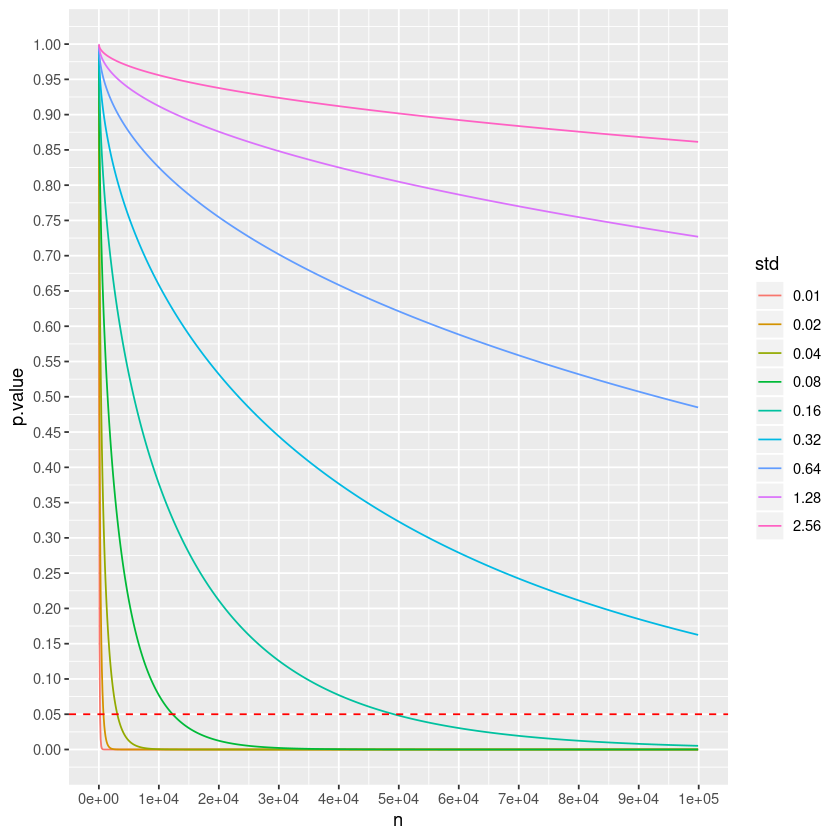

In [5]:
ggplot(result_student) + 
  geom_line(aes(x = n, y = p.value, color = as.factor(dist_std))) + 
  geom_hline(yintercept = 0.05, color = 'red', linetype = 'dashed') +
  scale_y_continuous(breaks = seq(0, 1, 0.05)) +
  scale_x_continuous(breaks = seq(0, 100000, 10000)) +
  scale_color_discrete(name = 'std')

A relationship is visible, for example, if the standard deviation is 0.08, the significance of 0.05 is achieved when the sample size is greater than 13000.

### Example of hypothesis testing (normal distribution)

We have the following dataset:

In [6]:
data_norm <- read.csv('data_norm.csv')

head(data_norm)

trip_id,feature,period
<int>,<dbl>,<fct>
0,0.04402347,before
1,0.03787196,before
2,0.05046686,before
3,0.08016472,before
4,0.07923912,before
5,0.03801651,before


There are 1000 observations in BEFORE period and 1000 AFTER.

**Purpose** - determine whether this change is significant..

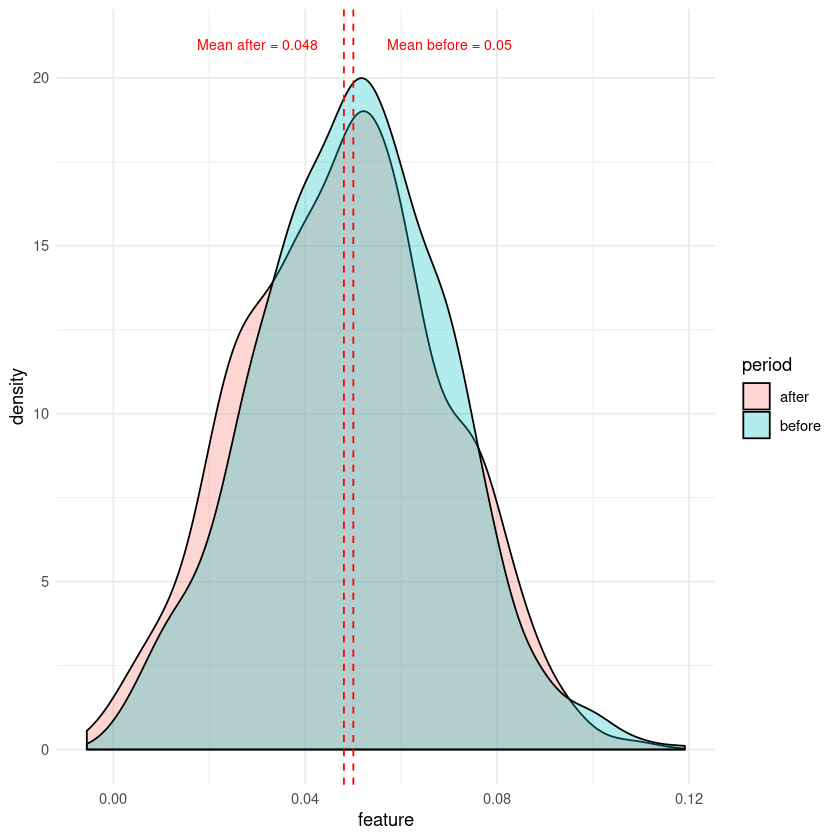

In [7]:
data_before <- data_norm %>% filter(period == 'before')
data_after <- data_norm %>% filter(period == 'after')

mean_before <- mean(data_before$feature)
mean_after <- mean(data_after$feature)

data_norm %>% ggplot(aes(x = feature, fill = period)) +
  geom_density(alpha = 0.3) + 
  geom_vline(xintercept = mean_before, color = 'red', linetype = 'dashed') +
  geom_vline(xintercept = mean_after, color = 'red', linetype = 'dashed') +
  annotate('text', x = 0.07, y = 21, label = paste0('Mean before = ', round(mean_before, 3)), 
           color = 'red', size = 3) + 
  annotate('text', x = 0.03, y = 21, label = paste0('Mean after = ', round(mean_after, 3)), 
           color = 'red', size = 3) +
  theme_minimal()

Samples' means are different. Let's look at the standard deviation.

In [8]:
print(paste0('sd = ', round(sd(data_norm$feature), 2)))

[1] "sd = 0.02"


To solve the problem, we'll apply [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) and estimate the statistical significance (alpha = 0.05).

In [9]:
t.test(data_before$feature, data_after$feature) 


	Welch Two Sample t-test

data:  data_before$feature and data_after$feature
t = 2.1694, df = 1993.1, p-value = 0.03017
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0001882836 0.0037350663
sample estimates:
 mean of x  mean of y 
0.05003201 0.04807034 


**p-value < alpha**, therefore, we reject [the null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis) on the equality of the two averages of the General population. **Conclusion** - observed changes are statistically **significant**.

## Bernoulli distribution

In this case only the size of the samples affects the significance.

In [10]:
result_fisher <- data.frame()

for (n in seq(1, 100000, 100)) {

  pos_before_n <- round(before_distribution_part * n)
  pos_after_n <- round(after_distribution_part * n)

  con_table <- matrix(
    c(pos_before_n, pos_after_n, n - pos_before_n, n - pos_after_n),
    nrow = 2,
    dimnames = list(group = c("Before", "After"), param = c("Pos", "Neg"))
  )

  test_res <- fisher.test(con_table)

  result_fisher <- result_fisher %>%
    bind_rows(
      data.frame(n = n, p.value = test_res$p.value)
    )
}

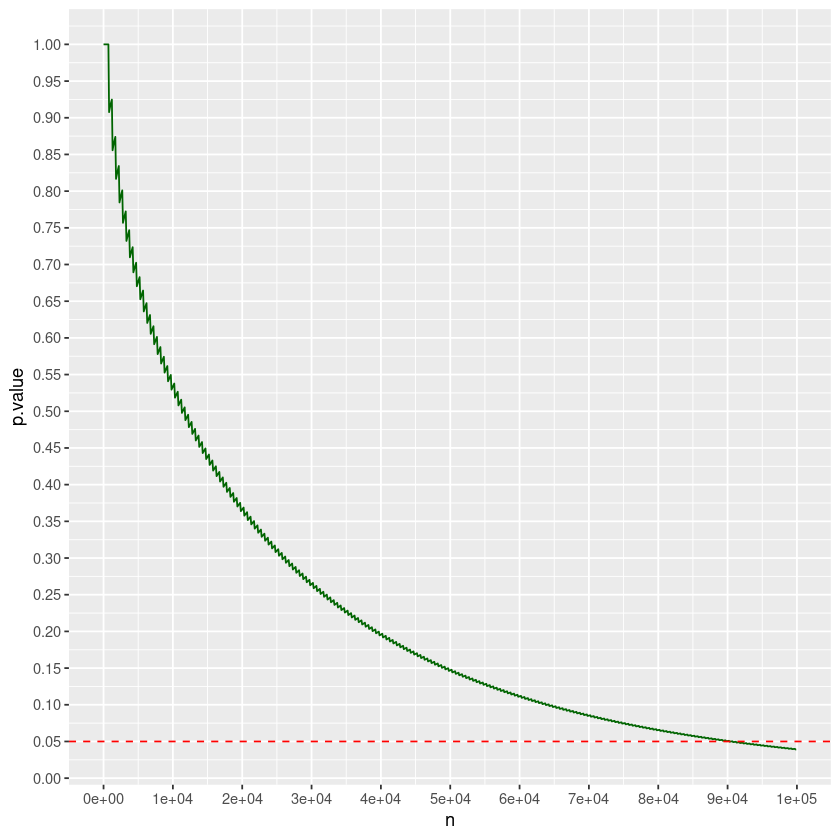

In [11]:
ggplot(result_fisher) + 
  geom_line(aes(x = n, y = p.value), color = 'darkgreen') + 
  geom_hline(yintercept = 0.05, color = 'red', linetype = 'dashed') +
  scale_y_continuous(breaks = seq(0, 1, 0.05)) +
  scale_x_continuous(breaks = seq(0, 100000, 10000))

The change is significant if the sample size before and after the change is greater than 90 000.

### Example of hypothesis testing (Bernoulli distribution)

We have the following dataset:

In [12]:
data_raw <- read.csv('data_bern.csv')

head(data_raw)

dt,user_id,is_view
<fct>,<int>,<int>
2018-11-20,108548,0
2018-11-20,113151,0
2018-11-20,121937,0
2018-11-20,239444,0
2018-11-20,352728,0
2018-11-20,500709,0


It contains information of four days, the first two of which - the period "before", the second - "after". Between these dates there was some *change*.

In [13]:
data_prep <- data_raw %>%
  mutate(group = ifelse(dt %in% c("2018-11-20","2018-11-21"), 'before', 'after'))
  
data_group <- data_prep %>% 
  group_by(group) %>% 
  summarise(
    count = n(),
    feature = round(mean(is_view) * 100, 2)
  )

data_group

group,count,feature
<chr>,<int>,<dbl>
after,2260,4.82
before,2260,5.04


The value of the sign after the change decreased by 0.22%.
**Purpose** - determine whether this change is significant.

To solve the problem we apply [Fischer exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) by constructing a contingency table for our Bernoulli distribution and estimating the statistical significance of the observed data (alpha = 0.05).

In [14]:
data_before <- data_prep %>% filter(group == 'before')
data_after <- data_prep %>% filter(group == 'after')

pos_before <- sum(data_before$is_view)
pos_after <- sum(data_after$is_view)
n <- length(data_before$is_view)

con_table <- matrix(
  c(pos_before, pos_after, n - pos_before, n - pos_after),
  nrow = 2,
  dimnames = list(group = c("Before", "After"), param = c("Pos", "Neg"))
)

test_res <- fisher.test(con_table)
p_value <- test_res$p.value

Contingency table and p-value:

In [15]:
con_table

print(paste0('p-value = ', round(p_value, 3)))

,Pos,Neg
Before,114,2146
After,109,2151


[1] "p-value = 0.784"


Calculated p-value > alpha, so we have no reason to reject the null hypothesis. **Conclusion** - observed changes are statistically **insignificant**.